# Transformer


In this notebook I will train a Transformer model preconfigured from huggingface.The dataset is Beijing air quality, from UCI machine learning repository.

In [1]:
# importing libraries

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from huggingface_hub import hf_hub_download
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cpu


In [3]:
device_count = torch.cuda.device_count()
print("Number of available devices:", device_count)

Number of available devices: 0


In [36]:
os.environ['PYTHONHASHSEED'] = str(42)
torch.backends.cudnn.deterministic = True
torch.manual_seed(42)
np.random.seed(42)

# reading csv file and dropping missing values


In [4]:
import pandas as pd
import numpy as np

def process_csv_file(file_path):
    file = pd.read_csv(file_path)
    file = file.dropna()
    
    
    date = (file["day"].astype(str) + "/" + file["month"].astype(str) + "/" + file["year"].astype(str) + "," + file["hour"].astype(str))
    pm = file["PM_US Post"]
    
    
    df = pd.DataFrame({"date": date, "PM2.5": pm})
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y,%H')
    df.set_index('date', inplace=True)

    df = df.resample('H').mean().interpolate(method='linear')

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year

    df['realhour'] = df['hour']
    df['realdayofweek'] = df['dayofweek']
    df['realmonth'] = df['month']

    df['hour'] = np.sin(df['hour'] * (2. * np.pi / 24))
    df['dayofweek'] = np.sin(df['dayofweek'] * (2. * np.pi / 7))
    df['month'] = np.sin(df['month'] * (2. * np.pi / 12))
    df['year'] = df['year'] - 2014
    
    return df[10000:20000]

beijing = process_csv_file('./beijing.csv')
shanghai = process_csv_file('./shanghai.csv')

df = beijing

beijing.head()

,PM2.5,hour,dayofweek,month,year,realhour,realdayofweek,realmonth
date,,,,,,,,
2014-04-26 00:00:00,65.987342,0.000000,-0.974928,0.866025,0,0,5,4
2014-04-26 01:00:00,64.683544,0.258819,-0.974928,0.866025,0,1,5,4
2014-04-26 02:00:00,63.379747,0.500000,-0.974928,0.866025,0,2,5,4
2014-04-26 03:00:00,62.075949,0.707107,-0.974928,0.866025,0,3,5,4
2014-04-26 04:00:00,60.772152,0.866025,-0.974928,0.866025,0,4,5,4


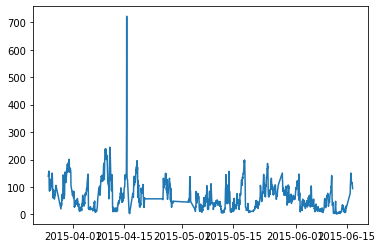

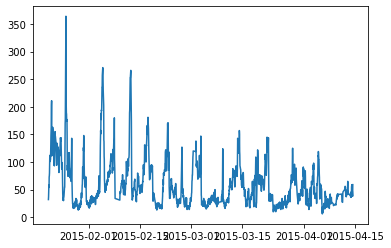

In [5]:
plt.plot(df['PM2.5'][8000:10000])
plt.show()

plt.plot(shanghai['PM2.5'][8000:10000])

## Autocorrelation for lag sequence


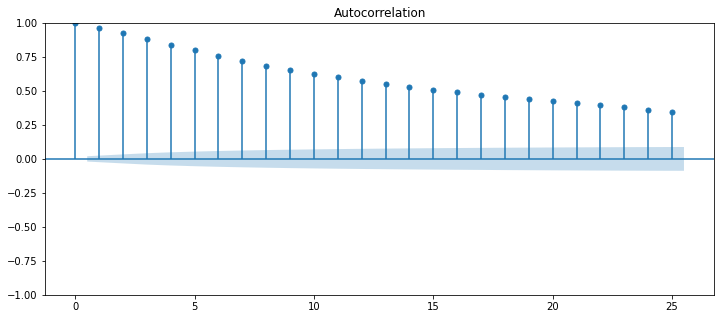

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pm25 = df['PM2.5']

# Plot the PACF of PM2.5 to determine lag sequence
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(pm25, lags=25, ax=ax)
plt.show()

## Window / sequence generator  +   future time features


In [7]:
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
    '''
    df: Pandas DataFrame of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(df)
    for i in range(L-tw-pw+1):
        # Option to drop target from dataframe
        if drop_targets:
            df.drop(target_columns, axis=1, inplace=True)

        # Get current sequence  
        sequence = df[i:i+tw].values
        # Get values right after the current sequence
        target = df[i+tw:i+tw+pw][target_columns].values

        # Check if sequence has correct length
        if len(sequence) != tw:
            raise ValueError(f"Sequence starting at index {i} has length {len(sequence)} instead of {tw}")

        data[i] = {'sequence': sequence, 'target': target}

    return data

class SequenceDataset():

    def __init__(self, df, pw):
        self.data = df
        self.pw = pw

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target']).view(-1, self.pw)

    def __len__(self):
        return len(self.data)
    

# function to determine the next time features
def get_future_time_features(last_time_features):
    
    hour = last_time_features[:,:,4]
    dayofweek = last_time_features[:,:,5]
    month = last_time_features[:,:,6]
    year = last_time_features[:,:,3]
    
    newhour = hour + 1
    
    # if newhour is 24, set it to 0 and increment dayofweek
    newdayofweek = torch.where(newhour == 24, dayofweek + 1, dayofweek)
    newhour = torch.where(newhour == 24, torch.tensor(0, dtype=torch.float), newhour)
    
    # set dayofweek to 1 and increment month if newdayofweek is 8
    newmonth = torch.where(newdayofweek == 8, month + 1, month)
    newdayofweek = torch.where(newdayofweek == 8, torch.tensor(1, dtype=torch.float), newdayofweek)
    
    # increment year if newmonth is 13
    newyear = torch.where(newmonth == 13, year + 1, year)
    newmonth = torch.where(newmonth == 13, torch.tensor(1, dtype=torch.float), newmonth)
    
    newhour = np.sin(newhour * (2. * np.pi / 24))
    newdayofweek = np.sin(newdayofweek * (2. * np.pi / 7))
    newmonth = np.sin(newmonth * (2. * np.pi / 12))
    
    new_time_features = torch.stack([newhour, newdayofweek, newmonth], dim=-1)
    
    return new_time_features



In [8]:
# Here we are defining properties for our model
sequence_len = 73

BATCH_SIZE = 64 # Training batch size
split = 0.8 # Train/Test Split ratio

sequences = generate_sequences(df, sequence_len, 3, 'PM2.5')
dataset = SequenceDataset(sequences, 3)

# Split the data into train, validation, and test sets
train_len = int(len(dataset)*split)
val_len = (len(dataset) - train_len) // 2
test_len = len(dataset) - train_len - val_len
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

torch.manual_seed(42)  # set a seed for reproducibility
np.random.seed(42)

# Load each subset into a separate DataLoader object
b_trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
b_valloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
b_testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


In [9]:

for x,y in b_trainloader:
    past_values = x[:, :, 0]
    past_time_features = x[:, :, 1:4]
    future_values = y
    last_time_features= x[:,-3:,1:]
#     print(last_time_features)[0]
    future_time_features = get_future_time_features(last_time_features)
    print(future_time_features[0])
    break


tensor([[ 2.5882e-01,  4.3388e-01,  1.0000e+00],
        [-8.7423e-08,  4.3388e-01,  1.0000e+00],
        [-2.5882e-01,  4.3388e-01,  1.0000e+00]])


Epoch 1
training loss:  5.3668
validation loss:  4.5366
Epoch 2
training loss:  4.2914
validation loss:  4.1003
Epoch 3
training loss:  4.0975
validation loss:  3.9892
Epoch 4
training loss:  4.0116
validation loss:  3.9377
Epoch 5
training loss:  3.9620
validation loss:  3.9338
Epoch 6
training loss:  3.9327
validation loss:  3.9095
Epoch 7
training loss:  3.8978
validation loss:  3.8369
Epoch 8
training loss:  3.8764
validation loss:  3.8139
Epoch 9
training loss:  3.8685
validation loss:  3.8373
Epoch 10
training loss:  3.8386
validation loss:  3.7935
Epoch 11
training loss:  3.8365
validation loss:  3.8090
Epoch 12
training loss:  3.8289
validation loss:  3.7750
Epoch 13
training loss:  3.7987
validation loss:  3.7689
Epoch 14
training loss:  3.7944
validation loss:  3.7831
Epoch 15
training loss:  3.7871
validation loss:  3.7716
Epoch 16
training loss:  3.7616
validation loss:  3.7372
Epoch 17
training loss:  3.7393
validation loss:  3.7689
Epoch 18
training loss:  3.7490
validati

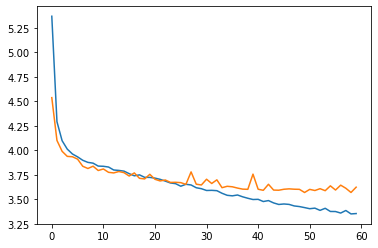

In [130]:
from transformers import TimeSeriesTransformerForPrediction
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
from transformers import AdamW

val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 1 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)

model = TimeSeriesTransformerForPrediction(configuration)
model.apply(lambda module: torch.manual_seed(42))

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in b_trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in b_valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [131]:

configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)


model = TimeSeriesTransformerForPrediction(configuration)

model.load_state_dict(torch.load('best_model.pt'))


print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
model.encoder.value_embedding.value_projection.weight 	 torch.Size([64, 7])
model.encoder.embed_positions.weight 	 torch.Size([74, 64])
model.encoder.layers.0.self_attn.k_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.k_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn.v_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.v_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn.q_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.q_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn.out_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.out_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn_layer_norm.weight 	 torch.Size([64])
model.encoder.layers.0.self_attn_layer_norm.bias 	 torch.Size([64])
model.encoder.layers.0.fc1.weight 	 torch.Size([32, 64])
model.encoder.layers.0.fc1.bias 	 torch.Size([32])
model.encoder.layers.0.fc2.weight 	 torch.Size([64, 32])
m

model.decoder.layers.2.self_attn_layer_norm.bias 	 torch.Size([64])
model.decoder.layers.2.encoder_attn.k_proj.weight 	 torch.Size([64, 64])
model.decoder.layers.2.encoder_attn.k_proj.bias 	 torch.Size([64])
model.decoder.layers.2.encoder_attn.v_proj.weight 	 torch.Size([64, 64])
model.decoder.layers.2.encoder_attn.v_proj.bias 	 torch.Size([64])
model.decoder.layers.2.encoder_attn.q_proj.weight 	 torch.Size([64, 64])
model.decoder.layers.2.encoder_attn.q_proj.bias 	 torch.Size([64])
model.decoder.layers.2.encoder_attn.out_proj.weight 	 torch.Size([64, 64])
model.decoder.layers.2.encoder_attn.out_proj.bias 	 torch.Size([64])
model.decoder.layers.2.encoder_attn_layer_norm.weight 	 torch.Size([64])
model.decoder.layers.2.encoder_attn_layer_norm.bias 	 torch.Size([64])
model.decoder.layers.2.fc1.weight 	 torch.Size([32, 64])
model.decoder.layers.2.fc1.bias 	 torch.Size([32])
model.decoder.layers.2.fc2.weight 	 torch.Size([64, 32])
model.decoder.layers.2.fc2.bias 	 torch.Size([64])
model.de

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate_model_rmse(model, dataloader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for x, y in dataloader:
            past_values = x[:, :, 0]
            past_time_features = x[:, :, 1:4]
            future_values = y.squeeze()
            last_time_features = x[:,-3:,1:]
            future_time_features = get_future_time_features(last_time_features)


            outputs = model.generate(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_time_features=future_time_features
            )
            
            mean_prediction = outputs.sequences.mean(dim=1)
            
            predictions.append(mean_prediction)
            targets.append(future_values)
            

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    mse = mean_squared_error(targets, predictions, multioutput='raw_values')
    rmse = np.sqrt(mse.mean())
    return rmse


from scipy.stats import pearsonr

def evaluate_model_pearson(model, dataloader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for x, y in dataloader:
            past_values = x[:, :, 0]
            past_time_features = x[:, :, 1:4]
            future_values = y.squeeze()
            last_time_features = x[:,-3:,1:]
            future_time_features = get_future_time_features(last_time_features)


            outputs = model.generate(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_time_features=future_time_features,
            )
            
            mean_prediction = outputs.sequences.mean(dim=1)
            
            predictions.append(mean_prediction)
            targets.append(y)
            

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    corr, _ = pearsonr(targets.numpy().ravel(), predictions.numpy().ravel())
    
    return abs(corr)


## Standard Transformer score


In [133]:

rmse = evaluate_model_rmse(model, b_testloader)
print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

RMSE: 24.5861
Pearson correlation:  0.9540


## Baseline score


This baseline model predicts the last known value three times.

In [11]:
def last_value_baseline(testloader):
    predictions = []
    targets = []
    for x, y in testloader:
        # append only the last value of the sequence 3 times
        last_value = x[:, -1, 0].unsqueeze(-1)
        prediction = torch.cat([last_value]*3, dim=1)
        predictions.append(prediction)
        # append the true y values
        targets.append(y.squeeze())
    
    # concatenate the predictions and targets along the batch dimension
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    
    return rmse

def last_value_baseline_pearson(testloader):
    predictions = []
    targets = []
    for x, y in testloader:
        # append only the last value of the sequence 3 times
        last_value = x[:, -1, 0].unsqueeze(-1)
        prediction = torch.cat([last_value]*3, dim=1)
        predictions.append(prediction)
        # append the true y values
        targets.append(y.squeeze())
    
    # concatenate the predictions and targets along the batch dimension
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    
    corr, _ = pearsonr(targets.numpy().ravel(), predictions.numpy().ravel())
    
    return corr

rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

RMSE: 27.614723
Pearson correlation:  0.9303


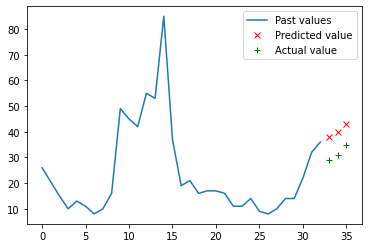

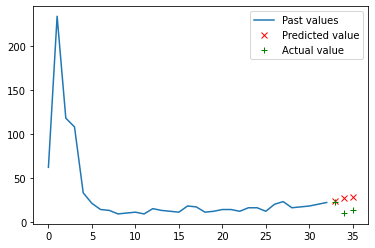

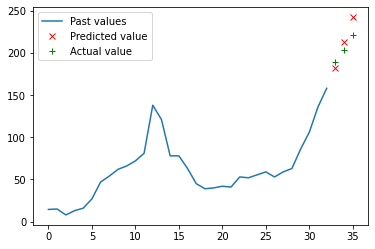

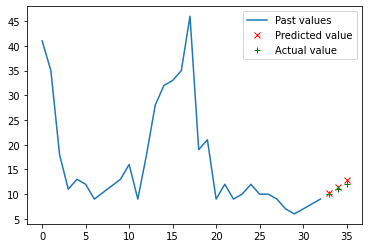

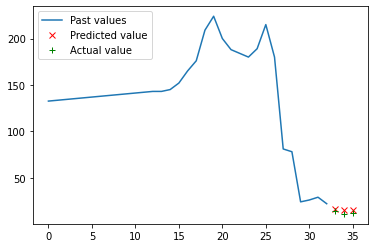

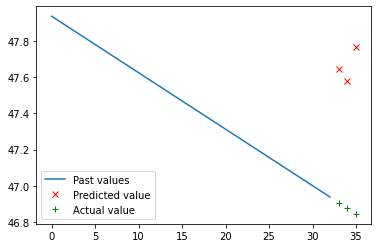

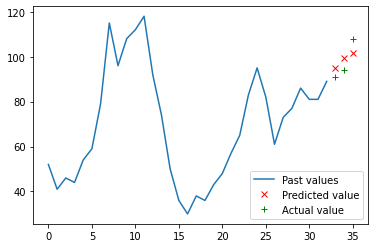

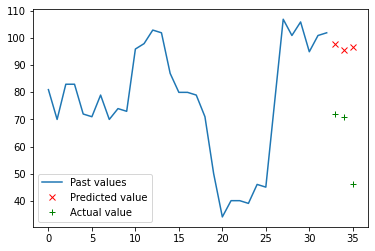

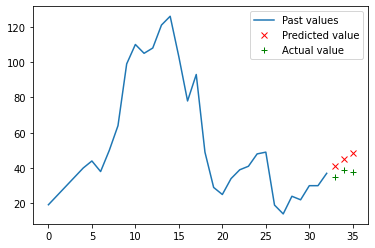

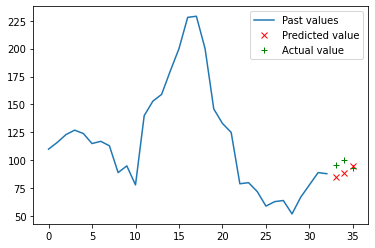

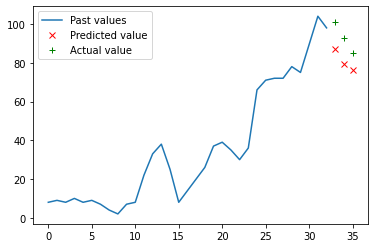

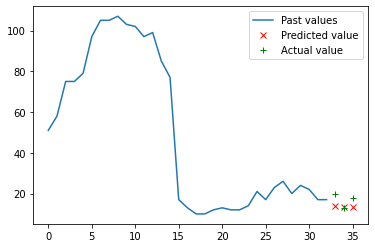

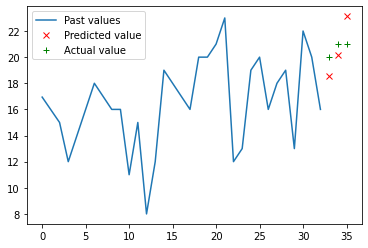

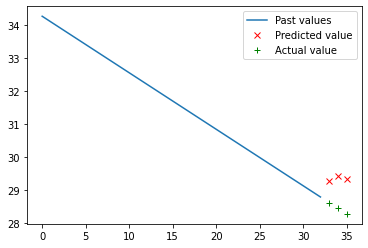

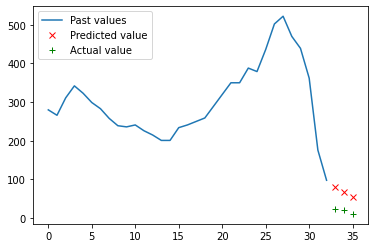

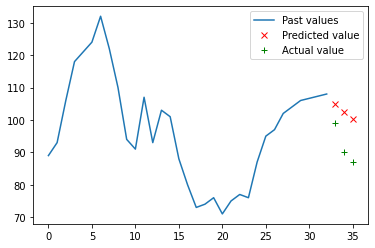

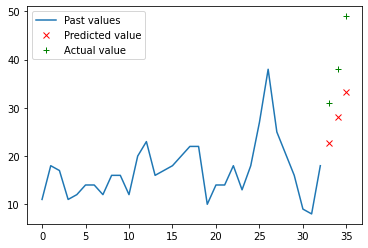

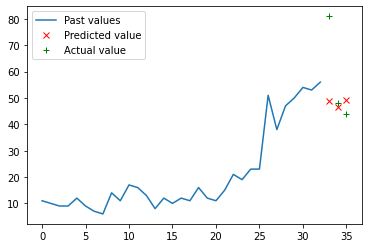

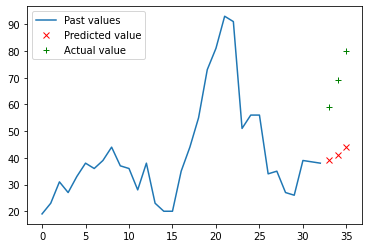

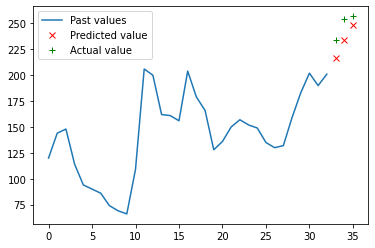

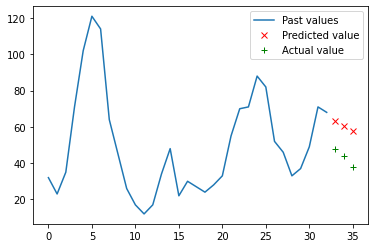

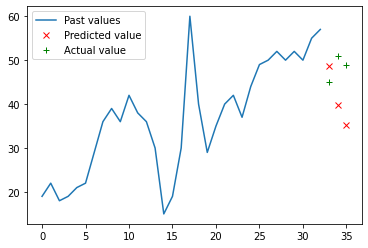

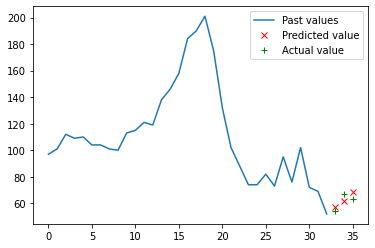

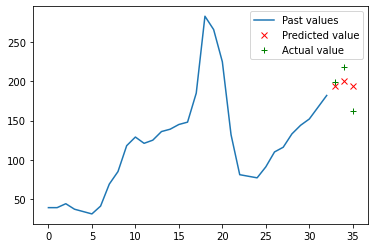

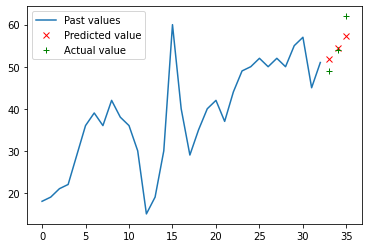

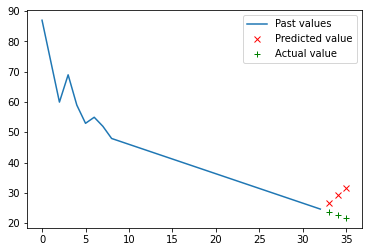

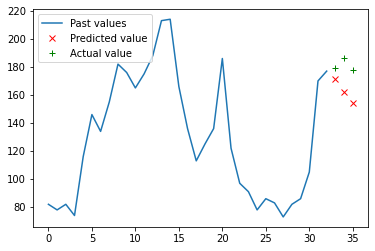

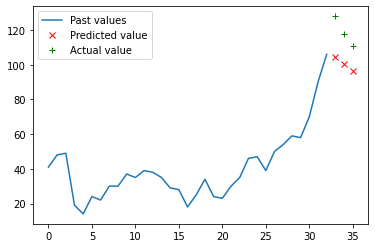

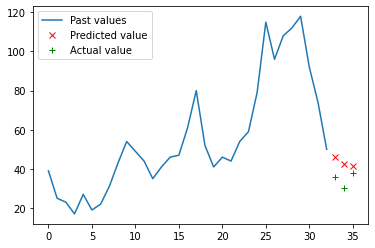

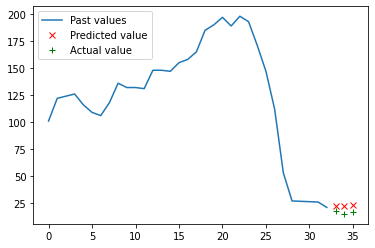

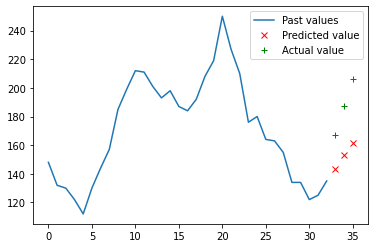

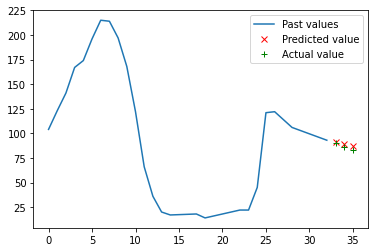

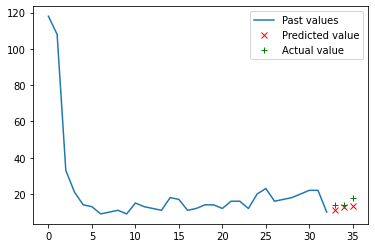

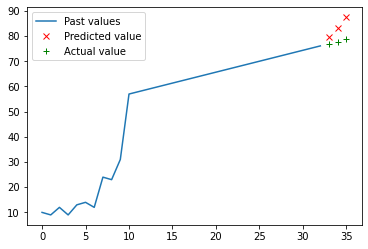

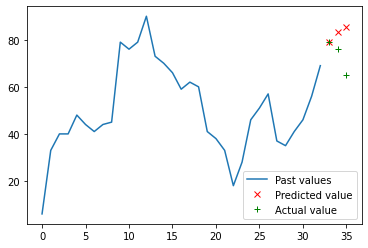

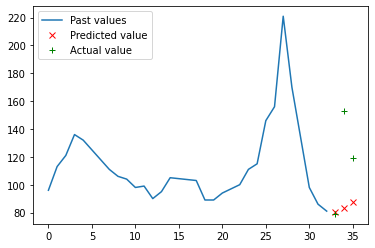

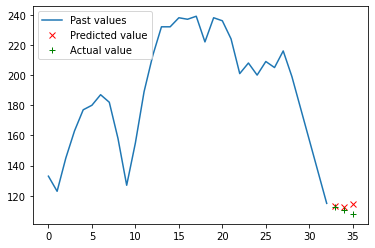

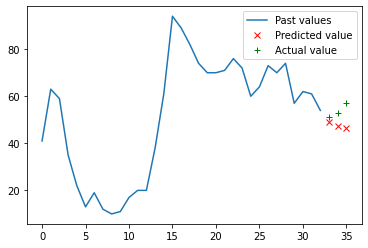

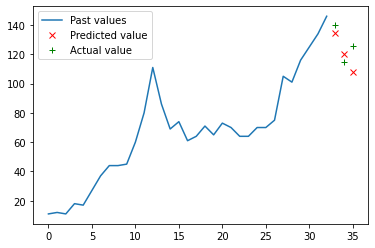

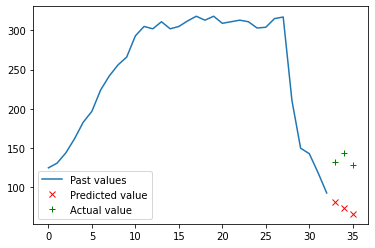

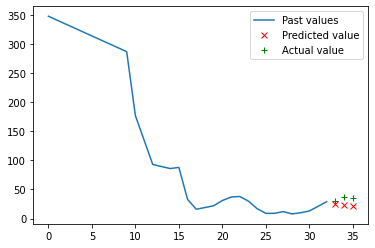

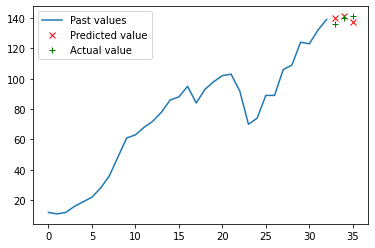

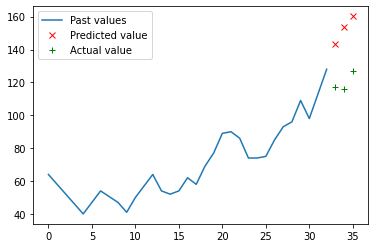

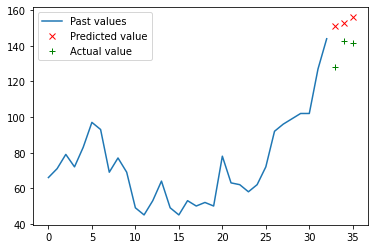

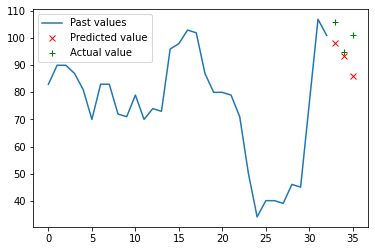

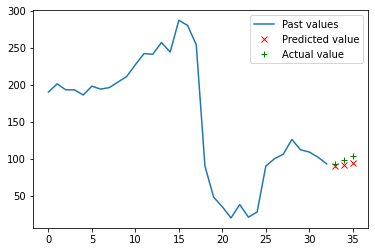

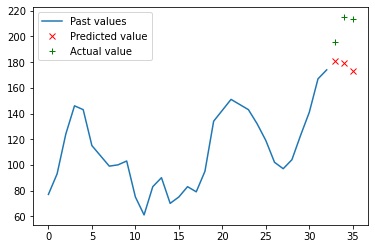

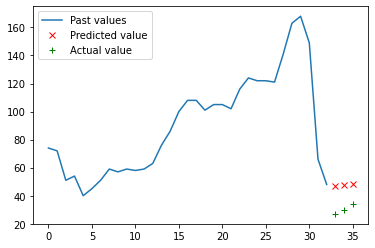

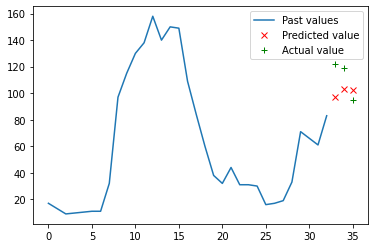

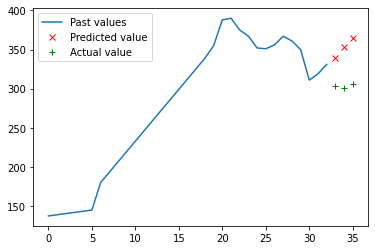

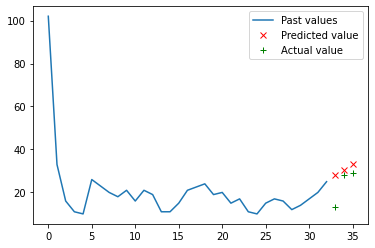

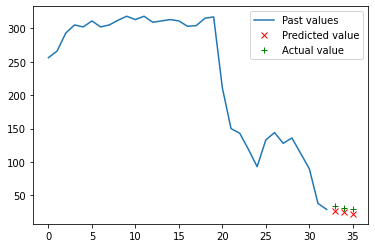

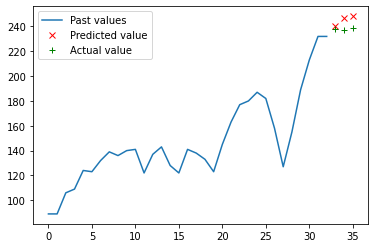

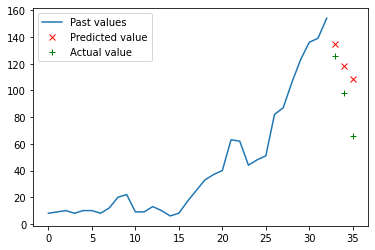

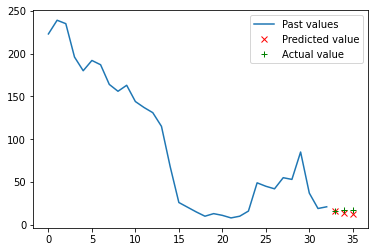

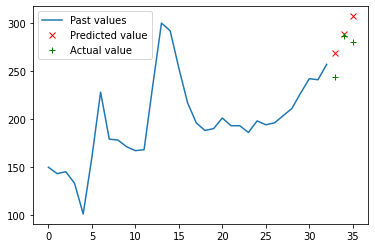

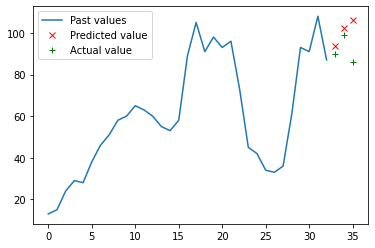

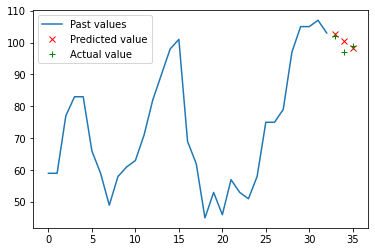

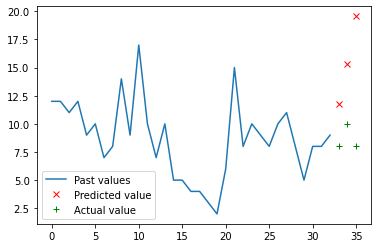

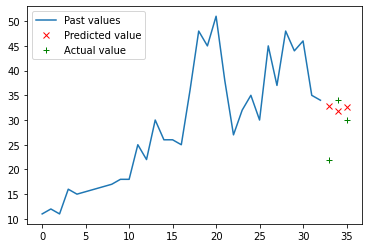

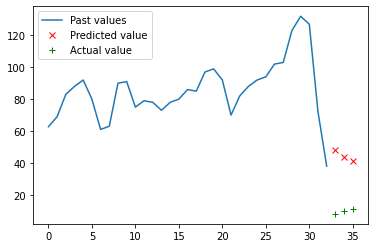

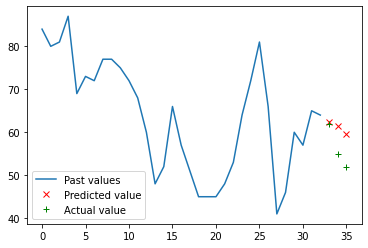

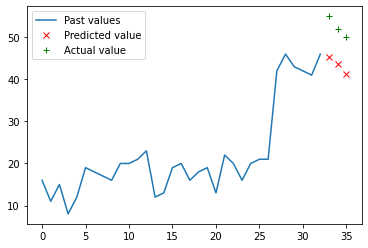

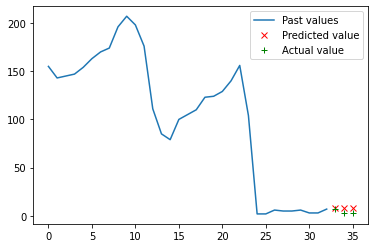

In [135]:
# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
mean_predictions = []
past_vals = []


outputs = model.generate(
    past_values=past_values,
    past_time_features=past_time_features,
    past_observed_mask=None,
    static_categorical_features=None,
    static_real_features=None,
    future_time_features=future_time_features,
)


mean_prediction = outputs.sequences.mean(dim=1)


for i in range(len(mean_prediction)):
    plt.plot(past_values[i][40:], label='Past values')
    plt.plot(range(33,36), mean_prediction[i], 'rx', label='Predicted value')
    plt.plot(range(33,36), future_values[i], 'g+', label='Actual value')
    #plt.plot(range(33,36), past_values[i][-24:-21], 'bo', label='Previous day baseline predictions')
    plt.legend()
    
    plt.show()

In [206]:
# create empty arrays to store actual and predicted values
actual_values = []
predicted_values = []

# loop through validation data and generate predictions
for x, y in b_valloader:
    y = y.squeeze()
    past_values = x[:, :, 0]
    past_time_features = x[:, :, 1:4]
    last_time_features = x[:,-3:,1:]
    future_time_features = get_future_time_features(last_time_features)

    outputs = model.generate(
        past_values=past_values,
        past_time_features=past_time_features,
        past_observed_mask=None,
        static_categorical_features=None,
        static_real_features=None,
        future_time_features=future_time_features, 
    )

    # append actual and predicted values to corresponding arrays
    actual_values.append(y.detach().numpy())
    predicted_values.append(outputs.sequences.mean(dim=1).detach().numpy())



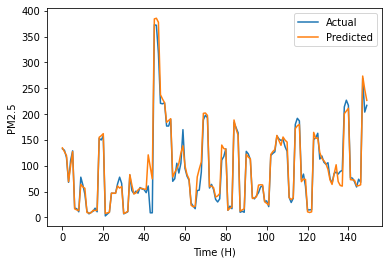

In [208]:
actual_values = np.array(actual_values).flatten()
predicted_values = np.array(predicted_values).flatten()
# plot actual and predicted values
plt.plot(actual_values[:150], label='Actual')
plt.plot(predicted_values[:150], label='Predicted')
plt.xlabel('Time (H)')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [38]:
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)


model = TimeSeriesTransformerForPrediction(configuration)

model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [12]:
df = shanghai

In [13]:
sequences = generate_sequences(df, sequence_len, 3, 'PM2.5')
dataset = SequenceDataset(sequences, 3)

# Split the data into train, validation, and test sets
train_len = int(len(dataset)*split)
val_len = (len(dataset) - train_len) // 2
test_len = len(dataset) - train_len - val_len
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

# Load each subset into a separate DataLoader object
s_trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_valloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
s_testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

### BEIJING SCORE

In [39]:
print("TRANSFORMER")
rmse = evaluate_model_rmse(model, b_testloader)
print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print("\n Baseline (last value)")
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

TRANSFORMER
RMSE: 24.5484
Pearson correlation:  0.9466

 Baseline (last value)


NameError: name 'last_value_baseline' is not defined

### SHANGHAI SCORE

In [142]:

print("TRANSFORMER")

rmse = evaluate_model_rmse(model, s_testloader)
print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print("\nBASELINE")
rmse = last_value_baseline(s_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

TRANSFORMER
RMSE: 16.4794
Pearson correlation:  0.9522

BASELINE
RMSE: 14.353771
Pearson correlation:  0.9192


# REGULARIZATION

Epoch 1
training loss:  5.4284
validation loss:  4.6023
Epoch 2
training loss:  4.3132
validation loss:  4.1344
Epoch 3
training loss:  4.1085
validation loss:  4.0544
Epoch 4
training loss:  4.0261
validation loss:  3.9300
Epoch 5
training loss:  3.9601
validation loss:  3.8824
Epoch 6
training loss:  3.9281
validation loss:  3.9130
Epoch 7
training loss:  3.9246
validation loss:  3.8493
Epoch 8
training loss:  3.8944
validation loss:  3.8379
Epoch 9
training loss:  3.8822
validation loss:  3.8744
Epoch 10
training loss:  3.8853
validation loss:  3.8010
Epoch 11
training loss:  3.8383
validation loss:  3.8427
Epoch 12
training loss:  3.8172
validation loss:  3.7792
Epoch 13
training loss:  3.8153
validation loss:  3.7740
Epoch 14
training loss:  3.8103
validation loss:  3.8012
Epoch 15
training loss:  3.8042
validation loss:  3.8014
Epoch 16
training loss:  3.7787
validation loss:  3.7439
Epoch 17
training loss:  3.7630
validation loss:  3.7972
Epoch 18
training loss:  3.7737
validati

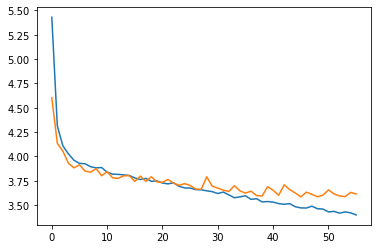

In [143]:
from transformers import TimeSeriesTransformerForPrediction
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
from transformers import AdamW

val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 3 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.4,
                                            attention_dropout=0.4,
                                            activation_dropout=0.4)

model = TimeSeriesTransformerForPrediction(configuration)
model.apply(lambda module: torch.manual_seed(42))

configuration = model.config
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in b_trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in b_valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), 'dropout_04_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### BEIJING

In [144]:
model.load_state_dict(torch.load('dropout_04_model.pt'))

rmse = evaluate_model_rmse(model, b_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))



*** Transformer scores ***
RMSE: 22.6712
Pearson correlation:  0.9417

*** Benchmark 2 (last value) ***
RMSE: 27.614723
Pearson correlation:  0.9303


### Shanghai

In [145]:
model.load_state_dict(torch.load('dropout_04_model.pt'))

rmse = evaluate_model_rmse(model, s_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))


print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(s_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))




*** Transformer scores ***
RMSE: 15.7715
Pearson correlation:  0.9422

*** Benchmark 2 (last value) ***
RMSE: 14.353771
Pearson correlation:  0.9192


# L1 REGULARIZATION

Epoch 1
training loss:  13.2268
validation loss:  11.5396
Epoch 2
training loss:  11.2146
validation loss:  11.0303
Epoch 3
training loss:  10.9971
validation loss:  10.8803
Epoch 4
training loss:  10.8670
validation loss:  10.7716
Epoch 5
training loss:  10.7795
validation loss:  10.6843
Epoch 6
training loss:  10.7038
validation loss:  10.6399
Epoch 7
training loss:  10.6532
validation loss:  10.5876
Epoch 8
training loss:  10.6153
validation loss:  10.5482
Epoch 9
training loss:  10.5781
validation loss:  10.5272
Epoch 10
training loss:  10.5248
validation loss:  10.4571
Epoch 11
training loss:  10.4817
validation loss:  10.4195
Epoch 12
training loss:  10.4417
validation loss:  10.3747
Epoch 13
training loss:  10.4058
validation loss:  10.3425
Epoch 14
training loss:  10.3650
validation loss:  10.2968
Epoch 15
training loss:  10.3170
validation loss:  10.2498
Epoch 16
training loss:  10.2760
validation loss:  10.2236
Epoch 17
training loss:  10.2509
validation loss:  10.2015
Epoch 

training loss:  9.6872
validation loss:  9.6666
Epoch 143
training loss:  9.6906
validation loss:  9.6582
Epoch 144
training loss:  9.6803
validation loss:  9.6439
Epoch 145
training loss:  9.6749
validation loss:  9.6636
Epoch 146
training loss:  9.6763
validation loss:  9.6473
Epoch 147
training loss:  9.6731
validation loss:  9.6371
Epoch 148
training loss:  9.6651
validation loss:  9.6397
Epoch 149
training loss:  9.6734
validation loss:  9.6349
Epoch 150
training loss:  9.6599
validation loss:  9.6286
Epoch 151
training loss:  9.6564
validation loss:  9.6626
Epoch 152
training loss:  9.6547
validation loss:  9.6180
Epoch 153
training loss:  9.6529
validation loss:  9.6186
Epoch 154
training loss:  9.6499
validation loss:  9.6170
Epoch 155
training loss:  9.6534
validation loss:  9.6299
Epoch 156
training loss:  9.6482
validation loss:  9.6280
Epoch 157
training loss:  9.6442
validation loss:  9.6043
Epoch 158
training loss:  9.6428
validation loss:  9.6129
Epoch 159
training loss:

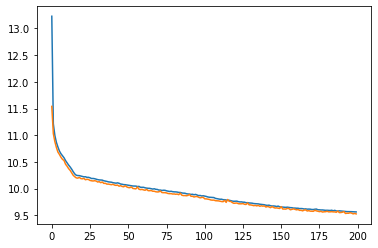

In [146]:
val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 1 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)

model = TimeSeriesTransformerForPrediction(configuration)
model.apply(lambda module: torch.manual_seed(42))
configuration = model.config
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

l1_lambda = 0.001  # set the strength of L1 regularization

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in b_trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        # L1 regularization
        l1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l1_reg = l1_reg + torch.norm(param, 1)
        loss = loss + l1_lambda * l1_reg
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in b_valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            
            # L1 regularization
            l1_reg = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_reg = l1_reg + torch.norm(param, 1)
            loss = loss + l1_lambda * l1_reg
            
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), 'L1_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### BEIJING

In [147]:
model.load_state_dict(torch.load('L1_model.pt'))

rmse = evaluate_model_rmse(model, b_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

*** Transformer scores ***
RMSE: 26.9823
Pearson correlation:  0.9412

*** Benchmark 2 (last value) ***
RMSE: 27.614723
Pearson correlation:  0.9303


### SHANGHAI (TEST)

In [148]:

rmse = evaluate_model_rmse(model, s_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(s_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

*** Transformer scores ***
RMSE: 14.8122
Pearson correlation:  0.9404

*** Benchmark 2 (last value) ***
RMSE: 14.353771
Pearson correlation:  0.9192


# L2 REGULARIZATION

Epoch 1
training loss:  5.5191
validation loss:  4.7733
Epoch 2
training loss:  4.6195
validation loss:  4.4420
Epoch 3
training loss:  4.4133
validation loss:  4.3488
Epoch 4
training loss:  4.3021
validation loss:  4.3131
Epoch 5
training loss:  4.2558
validation loss:  4.1749
Epoch 6
training loss:  4.2222
validation loss:  4.1639
Epoch 7
training loss:  4.2147
validation loss:  4.1617
Epoch 8
training loss:  4.1857
validation loss:  4.1582
Epoch 9
training loss:  4.1744
validation loss:  4.1182
Epoch 10
training loss:  4.1675
validation loss:  4.1271
Epoch 11
training loss:  4.1591
validation loss:  4.1057
Epoch 12
training loss:  4.1457
validation loss:  4.0985
Epoch 13
training loss:  4.1268
validation loss:  4.0853
Epoch 14
training loss:  4.1271
validation loss:  4.0799
Epoch 15
training loss:  4.1351
validation loss:  4.0777
Epoch 16
training loss:  4.1254
validation loss:  4.0706
Epoch 17
training loss:  4.1114
validation loss:  4.0745
Epoch 18
training loss:  4.1074
validati

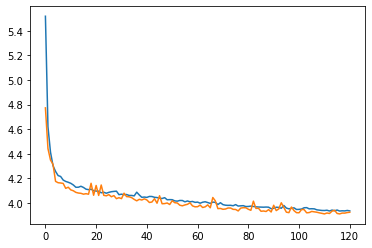

In [149]:
val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 1 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)

model = TimeSeriesTransformerForPrediction(configuration)
model.apply(lambda module: torch.manual_seed(42))
configuration = model.config
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

l2_lambda = 0.001  # set the strength of L2 regularization

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in b_trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        # L2 regularization
        l2_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l2_reg = l2_reg + torch.norm(param, 2)
        loss = loss + l2_lambda * l2_reg
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in b_valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            
            # L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l2_reg = l2_reg + torch.norm(param, 2)
            loss = loss + l2_lambda * l2_reg
            
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), 'L2_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### BEIJING

In [150]:
model.load_state_dict(torch.load('L2_model.pt'))

rmse = evaluate_model_rmse(model, b_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

*** Transformer scores ***
RMSE: 26.9469
Pearson correlation:  0.9438

*** Benchmark 2 (last value) ***
RMSE: 27.614723
Pearson correlation:  0.9303


### SHANGHAI

In [151]:
rmse = evaluate_model_rmse(model, s_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(s_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

*** Transformer scores ***
RMSE: 14.5776
Pearson correlation:  0.9431

*** Benchmark 2 (last value) ***
RMSE: 14.353771
Pearson correlation:  0.9192


# HYPERPARAMETER TUNING

dmodel = 16


In [ ]:
from transformers import TimeSeriesTransformerForPrediction
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
from transformers import AdamW

val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 1 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2,
                                            d_model=16)

model = TimeSeriesTransformerForPrediction(configuration)
model.apply(lambda module: torch.manual_seed(42))

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in b_trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in b_valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), '16_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### BEIJING

In [ ]:
model.load_state_dict(torch.load('16_model.pt'))

rmse = evaluate_model_rmse(model, b_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

### SHANGHAI

In [ ]:
rmse = evaluate_model_rmse(model, s_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(s_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

# HYPERPARAMTER TUNING

Encoder & decoder layers / 2


In [ ]:
from transformers import TimeSeriesTransformerForPrediction
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
from transformers import AdamW

val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 1 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=2,
                                            decoder_layers=2,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2,
                                            d_model=64)

model = TimeSeriesTransformerForPrediction(configuration)
model.apply(lambda module: torch.manual_seed(42))

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in b_trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in b_valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), 'half_encdec_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### BEIJING

In [ ]:
model.load_state_dict(torch.load('half_encdec_model.pt'))

rmse = evaluate_model_rmse(model, b_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

### SHANGHAI

In [ ]:
rmse = evaluate_model_rmse(model, s_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(s_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

# DATA AUGMENTATION
### Wavelet transform

In [19]:
df = beijing

import pywt

def add_wavelet_coefficients(df):
    # Make a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Define the wavelet function
    wavelet = 'db4'  # Example: Daubechies 4

    # Determine the maximum level of decomposition based on the dataframe length
    max_level = pywt.dwt_max_level(len(df_copy['PM2.5']), wavelet)

    # Apply wavelet decomposition to the PM2.5 variable
    coeffs = pywt.wavedec(df_copy['PM2.5'], wavelet, level=max_level)

    # Reconstruct the wavelet coefficients to match the dataframe length
    reconstructed = pywt.waverec(coeffs[:max_level] + [None] * (len(coeffs) - max_level), wavelet)

    # Create new column for the wavelet coefficients
    df_copy['wavelet_coefficients'] = reconstructed[:len(df_copy)]

    return df_copy

# Create a copy of the 'beijing' dataframe with the wavelet coefficients added
beijing_with_wavelet = add_wavelet_coefficients(beijing)

beijing_with_wavelet.head(n=100)

,PM2.5,hour,dayofweek,month,year,realhour,realdayofweek,realmonth,wavelet_coefficients
date,,,,,,,,,
2014-04-26 00:00:00,65.987342,0.000000,-0.974928,0.866025,0,0,5,4,66.005348
2014-04-26 01:00:00,64.683544,0.258819,-0.974928,0.866025,0,1,5,4,64.626957
2014-04-26 02:00:00,63.379747,0.500000,-0.974928,0.866025,0,2,5,4,63.420284
2014-04-26 03:00:00,62.075949,0.707107,-0.974928,0.866025,0,3,5,4,62.116844
2014-04-26 04:00:00,60.772152,0.866025,-0.974928,0.866025,0,4,5,4,60.711874
...,...,...,...,...,...,...,...,...,...
2014-04-29 23:00:00,103.000000,-0.258819,0.781831,0.866025,0,23,1,4,97.795867
2014-04-30 00:00:00,89.000000,0.000000,0.974928,0.866025,0,0,2,4,93.486168
2014-04-30 01:00:00,89.000000,0.258819,0.974928,0.866025,0,1,2,4,90.531272


In [20]:
df = beijing_with_wavelet

# Here we are defining properties for our model
sequence_len = 73

BATCH_SIZE = 64 # Training batch size
split = 0.8 # Train/Test Split ratio

sequences = generate_sequences(df, sequence_len, 3, 'wavelet_coefficients')
dataset = SequenceDataset(sequences, 3)

# Split the data into train, validation, and test sets
train_len = int(len(dataset)*split)
val_len = (len(dataset) - train_len) // 2
test_len = len(dataset) - train_len - val_len
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])


# Load each subset into a separate DataLoader object
b_wavelet_trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

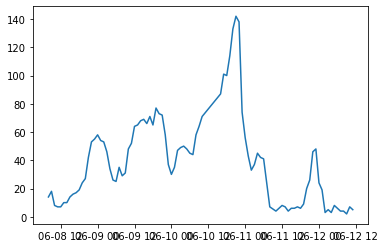

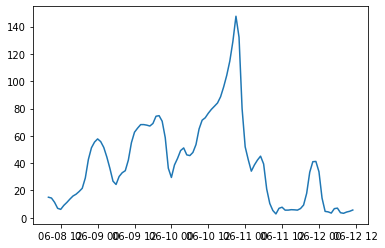

In [25]:
plt.plot(beijing['PM2.5'][-200:-100])
plt.show()

plt.plot(df['wavelet_coefficients'][-200:-100])

Epoch 1
training loss:  5.3665
validation loss:  4.6231
Epoch 2
training loss:  4.2332
validation loss:  4.1197
Epoch 3
training loss:  3.9746
validation loss:  3.9390
Epoch 4
training loss:  3.8229
validation loss:  3.8798
Epoch 5
training loss:  3.7417
validation loss:  3.9040
Epoch 6
training loss:  3.6903
validation loss:  3.8924
Epoch 7
training loss:  3.6496
validation loss:  3.8902
Epoch 8
training loss:  3.6468
validation loss:  3.8872
Epoch 9
training loss:  3.6085
validation loss:  3.8716
Epoch 10
training loss:  3.6086
validation loss:  3.8423
Epoch 11
training loss:  3.6006
validation loss:  3.8828
Epoch 12
training loss:  3.5928
validation loss:  3.8353
Epoch 13
training loss:  3.5704
validation loss:  3.9094
Epoch 14
training loss:  3.5567
validation loss:  3.8120
Epoch 15
training loss:  3.5563
validation loss:  3.8742
Epoch 16
training loss:  3.5814
validation loss:  3.9102
Epoch 17
training loss:  3.5512
validation loss:  3.7984
Epoch 18
training loss:  3.5226
validati

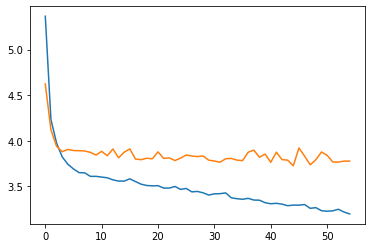

In [26]:
val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 3 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)

model = TimeSeriesTransformerForPrediction(configuration)
model.apply(lambda module: torch.manual_seed(42))

configuration = model.config
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in b_wavelet_trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in b_valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), 'wavelet_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### BEIJING

In [31]:
model.load_state_dict(torch.load('wavelet_model.pt'))

rmse = evaluate_model_rmse(model, b_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(b_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

*** Transformer scores ***
RMSE: 25.1801
Pearson correlation:  0.9419

*** Benchmark 2 (last value) ***


NameError: name 'last_value_baseline' is not defined

### SHANGHAI

In [36]:
rmse = evaluate_model_rmse(model, s_testloader)


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

pearson = evaluate_model_pearson(model, s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(s_testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(s_testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

*** Transformer scores ***
RMSE: 15.2287
Pearson correlation:  0.9166

*** Benchmark 2 (last value) ***


NameError: name 'last_value_baseline' is not defined

# ENSEMBLE METHODS

Bagging

In [16]:
val_losses = []
train_losses = []

max_epochs = 200
num_models = 5

# Initializing a Time Series Transformer configuration with 3 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)

# Initialize lists to store the bagging models and their performance
bagging_models = []
bagging_val_losses = []

# Train and evaluate the bagging models
for i in range(num_models):
    counter = 0
    patience = 0
    best_val_loss = float('inf')

    # Initialize a new model
    model = TimeSeriesTransformerForPrediction(configuration)
    model.apply(lambda module: torch.manual_seed(i))  # Set a different seed for each model

    configuration = model.config
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

    for epoch in range(max_epochs):

        counter += 1
        print('Epoch', counter)

        mean_loss = []

        for x,y in b_trainloader:
            # during training, one provides both past and future values
            # as well as possible additional features
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)

            outputs = model(
                past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
                past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,                           # shape: (batch_size, prediction_length)
                future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
            )

            loss = outputs.loss

            mean_loss.append(loss.item())

            loss.backward()
            optimizer.step() # update parameters
            optimizer.zero_grad() # reset gradients

        avg_loss = sum(mean_loss) / len(mean_loss)

        train_losses.append(avg_loss)
        print('training loss: ', "{:.4f}".format(avg_loss))

        mean_loss = []

        model.eval()
        with torch.no_grad():
            for x, y in b_valloader:
                past_values = x[:, :, 0]
                past_time_features = x[:,:,1:4]
                last_time_features = x[:,-3:,1:]
                future_values = y.squeeze()
                future_time_features = get_future_time_features(last_time_features)

                outputs = model(
                    past_values=past_values,
                    past_time_features=past_time_features,
                    past_observed_mask=None,
                    static_categorical_features=None,
                    static_real_features=None,
                    future_values=future_values,
                    future_time_features=future_time_features,
                )

                loss = outputs.loss
                mean_loss.append(loss.item())

        avg_loss = sum(mean_loss) / len(mean_loss)
        val_losses.append(avg_loss)
        print('validation loss: ', "{:.4f}".format(avg_loss))

        # Early stopping with patience of 5 and restoring the best weights
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            patience = 0
            torch.save(model.state_dict(), f'bag_model_{i}.pt')
        else:
            patience += 1
            if patience >= 10:
                print('Early stopping at epoch', epoch)
                break
            else:
                continue
    
    bagging_models.append(model)
    bagging_val_losses.append(best_val_loss)
    
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.show()

Epoch 1
training loss:  5.3926
validation loss:  4.6321
Epoch 2


KeyboardInterrupt: 

### BEIJING

In [ ]:
ensemble_predictions = []


with torch.no_grad():
    for model in bagging_models:
        model.eval()
        predictions = []
        targets = []
        for x, y in b_testloader:
            past_values = x[:, :, 0]
            past_time_features = x[:, :, 1:4]
            future_values = y.squeeze()
            last_time_features = x[:,-3:,1:]
            future_time_features = get_future_time_features(last_time_features)

            outputs = model.generate(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_time_features=future_time_features
            )

            mean_prediction = outputs.sequences.mean(dim=1)
            targets.append(future_values)
            predictions.append(mean_prediction)
        
        targets = torch.cat(targets)
        predictions = torch.cat(predictions)
        ensemble_predictions.append(predictions)

ensemble_predictions = torch.stack(ensemble_predictions)
ensemble_predictions_mean = ensemble_predictions.mean(dim=0)
targets = torch.cat(targets)

mse = mean_squared_error(targets, ensemble_predictions_mean, multioutput='raw_values')
rmse = np.sqrt(mse.mean())


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

# pearson = evaluate_model_pearson(model, b_testloader)
# print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

# pearson_baseline = last_value_baseline_pearson(b_testloader)
# print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

### SHANGHAI

In [ ]:
ensemble_predictions = []
targets = []

with torch.no_grad():
    for model in bagging_models:
        model.eval()
        predictions = []
        for x, y in s_testloader:
            past_values = x[:, :, 0]
            past_time_features = x[:, :, 1:4]
            future_values = y.squeeze()
            last_time_features = x[:,-3:,1:]
            future_time_features = get_future_time_features(last_time_features)

            outputs = model.generate(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_time_features=future_time_features
            )

            mean_prediction = outputs.sequences.mean(dim=1)
            targets.append(future_values)
            predictions.append(mean_prediction)
        
        targets = torch.cat(targets)
        predictions = torch.cat(predictions)
        ensemble_predictions.append(predictions)

ensemble_predictions = torch.stack(ensemble_predictions)
ensemble_predictions_mean = ensemble_predictions.mean(dim=0)
targets = torch.cat(targets)

mse = mean_squared_error(targets, ensemble_predictions_mean, multioutput='raw_values')
rmse = np.sqrt(mse.mean())


print('*** Transformer scores ***')

print('RMSE:', "{:.4f}".format(rmse))

# pearson = evaluate_model_pearson(model, b_testloader)
# print("Pearson correlation: ", "{:.4f}".format(pearson))

print('\n*** Benchmark 2 (last value) ***')
rmse = last_value_baseline(b_testloader)
print('RMSE:', rmse)

# pearson_baseline = last_value_baseline_pearson(b_testloader)
# print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

### BOOSTING

In [33]:
val_losses = []
train_losses = []
max_epochs = 200
num_models = 5
boosting_models = []
boosting_val_losses = []
original_time_series_data = []
original_time_series_data = torch.tensor([])

# Initializing a Time Series Transformer configuration with 3 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)

# Train and evaluate the boosting models
for i in range(num_models):
    counter = 0
    patience = 0
    best_val_loss = float('inf')

    # Initialize a new model
    model = TimeSeriesTransformerForPrediction(configuration)
    model.apply(lambda module: torch.manual_seed(i))  # Set a different seed for each model

    configuration = model.config
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

    for epoch in range(max_epochs):

        counter += 1
        print('Epoch', counter)

        mean_loss = []

        for x, y in b_trainloader:
            # during training, one provides both past and future values
            # as well as possible additional features
            past_values = x[:, :, 0]
            past_time_features = x[:, :, 1:4]
            last_time_features = x[:, -3:, 1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            if i == 0:
                original_time_series_data_tensor = future_values
            elif i > 0:
                original_time_series_data_tensor = torch.cat(original_time_series_data, dim=0)
                original_time_series_data_tensor -= model(past_values, past_time_features).mean(dim=1)
            
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=original_time_series_data_tensor,
                future_time_features=future_time_features,
            )

            loss = outputs.loss

            mean_loss.append(loss.item())

            loss.backward()
            optimizer.step()  # update parameters
            optimizer.zero_grad()  # reset gradients

        avg_loss = sum(mean_loss) / len(mean_loss)

        train_losses.append(avg_loss)
        print('training loss: ', "{:.4f}".format(avg_loss))

        mean_loss = []

        model.eval()
        with torch.no_grad():
            for x, y in b_valloader:
                past_values = x[:, :, 0]
                past_time_features = x[:, :, 1:4]
                last_time_features = x[:, -3:, 1:]
                future_values = y.squeeze()
                future_time_features = get_future_time_features(last_time_features)

                outputs = model(
                    past_values=past_values,
                    past_time_features=past_time_features,
                    past_observed_mask=None,
                    static_categorical_features=None,
                    static_real_features=None,
                    future_values=future_values,
                    future_time_features=future_time_features,
                )

                loss = outputs.loss
                mean_loss.append(loss.item())

        avg_loss = sum(mean_loss) / len(mean_loss)
        val_losses.append(avg_loss)
        print('validation loss: ', "{:.4f}".format(avg_loss))

        # Early stopping with patience of 5 and restoring the best weights
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            patience = 0
            torch.save(model.state_dict(), f'boosting_model_{i}.pt')
        else:
            patience += 1
            if patience >= 10:
                print('Early stopping at epoch', epoch)
                break
            else:
                continue

    boosting_models.append(model)
    boosting_val_losses.append(best_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


Epoch 1
training loss:  5.2945
validation loss:  4.6335
Epoch 2
training loss:  4.3344
validation loss:  4.1529
Epoch 3


KeyboardInterrupt: 